In [83]:
from collections import defaultdict
from pathlib import Path
from pprint import pprint

import numpy as np
import yaml
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
from itertools import product
import pandas as pd

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_sweep"
PLOT_PATH = Path().resolve() / "plots"

##### Plot 1: Regression performance

In [84]:
# load regression results
reg_res = defaultdict(lambda: defaultdict(dict))

for task_type in PRED_PATH.iterdir():
    for method_dir in task_type.iterdir():
        if method_dir.is_dir():
            for dataset_dir in method_dir.iterdir():
                if dataset_dir.is_dir():
                    fp = dataset_dir / "metadata.yaml"

                    if not fp.exists():
                        continue

                    with open(fp, "r") as f:
                        reg_res[task_type.name][method_dir.name][dataset_dir.name] = (
                            yaml.safe_load(f)
                        )


reg_res = {k: dict(v) for k, v in reg_res.items()}

In [85]:
for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        print(len(datasets), task_type, method)

58 class xgboost
58 class jp_const_gb_part_l2
58 class gb
98 regr xgboost
98 regr jp_const_gb_part_l2
95 regr cb
98 regr gb


In [86]:
# only keep datasets shared by all methods
shared_datasets = defaultdict(lambda: defaultdict(set))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        # if len(datasets) in [10, 69]:
        #     continue

        for contains_categorical in [True, False, "postprocessed"]:
            keys = [
                k
                for k, v in datasets.items()
                if v["contains_categorical"] == contains_categorical
            ]

            if not shared_datasets[task_type][contains_categorical]:
                shared_datasets[task_type][contains_categorical] = set(keys)
            else:
                shared_datasets[task_type][contains_categorical] &= set(keys)

new_reg_res = defaultdict(lambda: defaultdict(dict))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        for contains_categorical in [True, False, "postprocessed"]:
            new_reg_res[task_type][method].update(
                {
                    k: v
                    for k, v in datasets.items()
                    if k in shared_datasets[task_type][contains_categorical]
                }
            )

reg_res = {k: dict(v) for k, v in new_reg_res.items()}

In [87]:
for task_type, methods in reg_res.items():
    for contains_categorical in [True, False, "postprocessed"]:
        print(
            task_type,
            contains_categorical,
            len(shared_datasets[task_type][contains_categorical]),
        )
        print(shared_datasets[task_type][contains_categorical])

class True 0
set()
class False 21
{'ring', 'sonar', 'analcatdata_japansolvent', 'clean1', 'breast_cancer_wisconsin', 'diabetes', 'glass2', 'magic', 'Hill_Valley_with_noise', 'pima', 'analcatdata_bankruptcy', 'lupus', 'twonorm', 'haberman', 'appendicitis', 'prnn_synth', 'phoneme', 'clean2', 'spambase', 'wdbc', 'spectf'}
class postprocessed 37
{'analcatdata_asbestos', 'dis', 'labor', 'analcatdata_boxing2', 'cleve', 'churn', 'german', 'analcatdata_cyyoung8092', 'analcatdata_boxing1', 'credit_g', 'profb', 'prnn_crabs', 'tokyo1', 'credit_a', 'colic', 'heart_h', 'crx', 'biomed', 'coil2000', 'analcatdata_lawsuit', 'heart_c', 'backache', 'buggyCrx', 'horse_colic', 'analcatdata_aids', 'australian', 'analcatdata_cyyoung9302', 'ionosphere', 'agaricus_lepiota', 'breast_w', 'hypothyroid', 'hungarian', 'breast_cancer', 'breast', 'hepatitis', 'heart_statlog', 'analcatdata_creditscore'}
regr True 0
set()
regr False 84
{'637_fri_c1_500_50', '608_fri_c3_1000_10', '646_fri_c3_500_10', '626_fri_c2_500_50'

In [88]:
def plot_strip(
    reg_res: dict,
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
    # only_continuous: bool = False,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    def score(vv: dict, only_classification: bool):
        # print(vv)
        if only_classification:
            return vv["metadata"]["test"]["zo_loss"]
        else:
            return vv["test_score"] / vv["dummy_loss"]

    rescaled_res = {
        k: {
            kk: score(vv, only_classification)
            for kk, vv in v.items()
            # if not vv["contains_categorical"]
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    median_res = {k: np.median(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {
        k: rescaled_res[k] for k in sorted(median_res, key=median_res.get)[::-1]
    }

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    fig, ax = plt.subplots(figsize=(10, len(rescaled_res) * 2 / 3), **plot_kwargs)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, **scatter_kwargs)

    x_lim = (0, max(ax.get_xlim()[1], 1.2))
    x_lim = (0, min(x_lim[1], 1 if only_classification else 1.5))

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for median for each model
    medians = [np.median(list(val)) for val in x_values]
    for x_value, median in zip(range(len(x_values)), medians):
        ax.vlines(median, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, medians)})

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)

    if not only_classification:
        ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")

    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    plt.xlabel("Normalized Loss" if not only_classification else "Zero-One Loss")

    plt.tight_layout()

    return ax, medians


def compare_methods(reg_res1, reg_res2, is_classification):
    method1, method2 = [], []

    for k, v in reg_res1.items():
        if k in reg_res2:
            v2 = reg_res2[k]

            if is_classification:
                method1.append(v["metadata"]["test"]["zo_loss"])
                method2.append(v2["metadata"]["test"]["zo_loss"])
            else:
                method1.append(v["test_score"] / v["dummy_loss"])
                method2.append(v2["test_score"] / v2["dummy_loss"])

    return wilcoxon(method1, method2, alternative="less").pvalue

Only class: True, Only cont: True
{'gb': 0.16666666666666663, 'xgboost': 0.16666666666666663, 'jp_const_gb_part_l2': 0.1463768115942029}


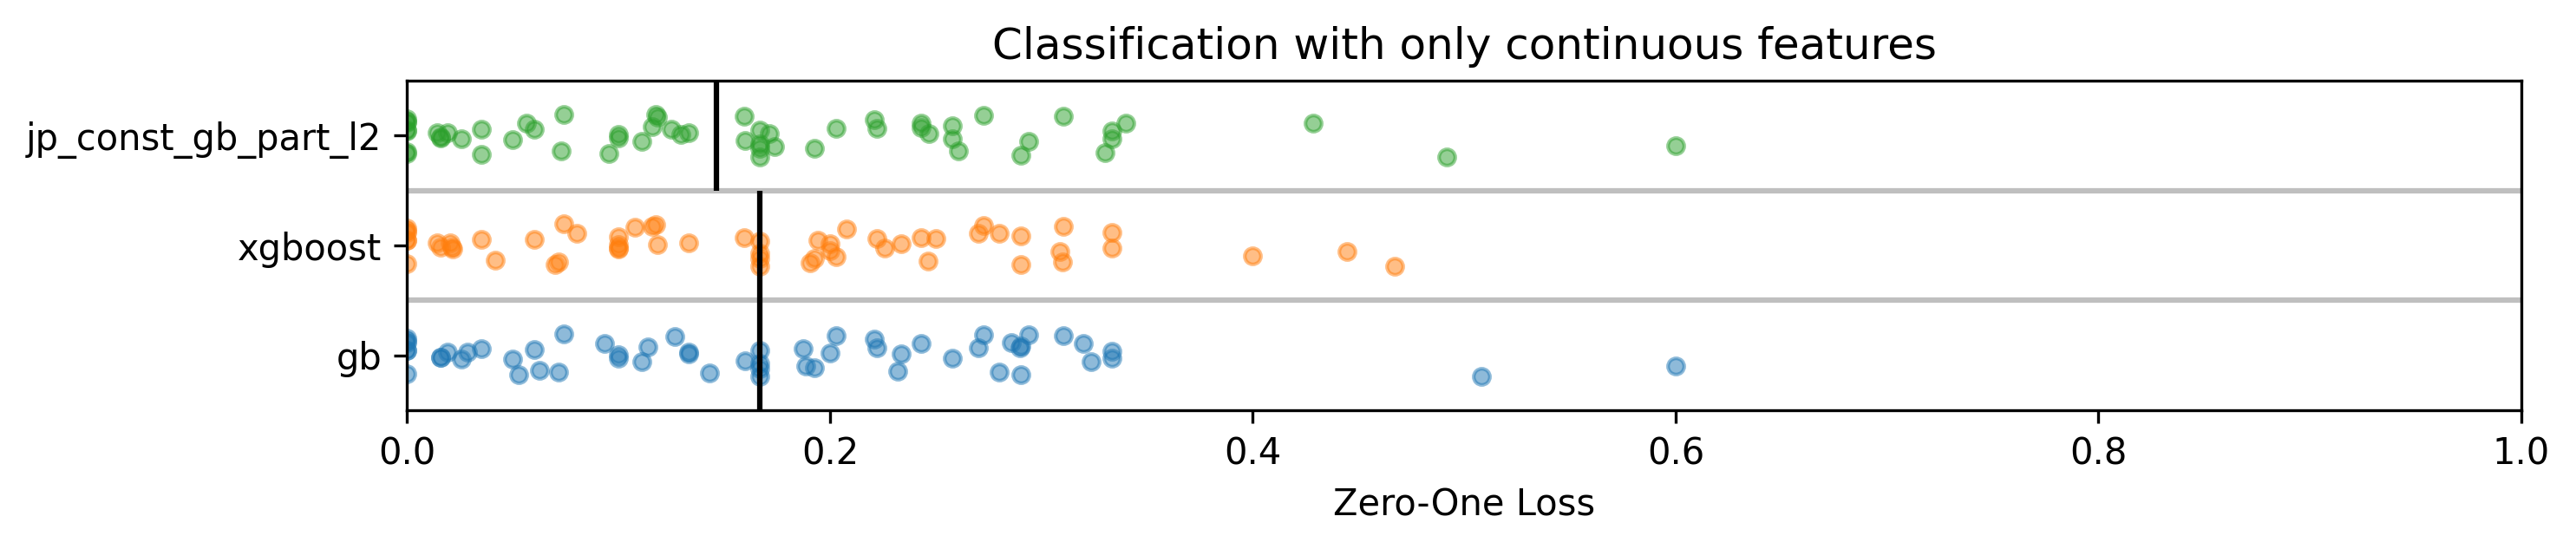

There ar 58 datasets
Only class: False, Only cont: True
{'xgboost': 0.38819075685025506, 'gb': 0.36070242590870943, 'cb': 0.33779035090391496, 'jp_const_gb_part_l2': 0.31008867608656593}


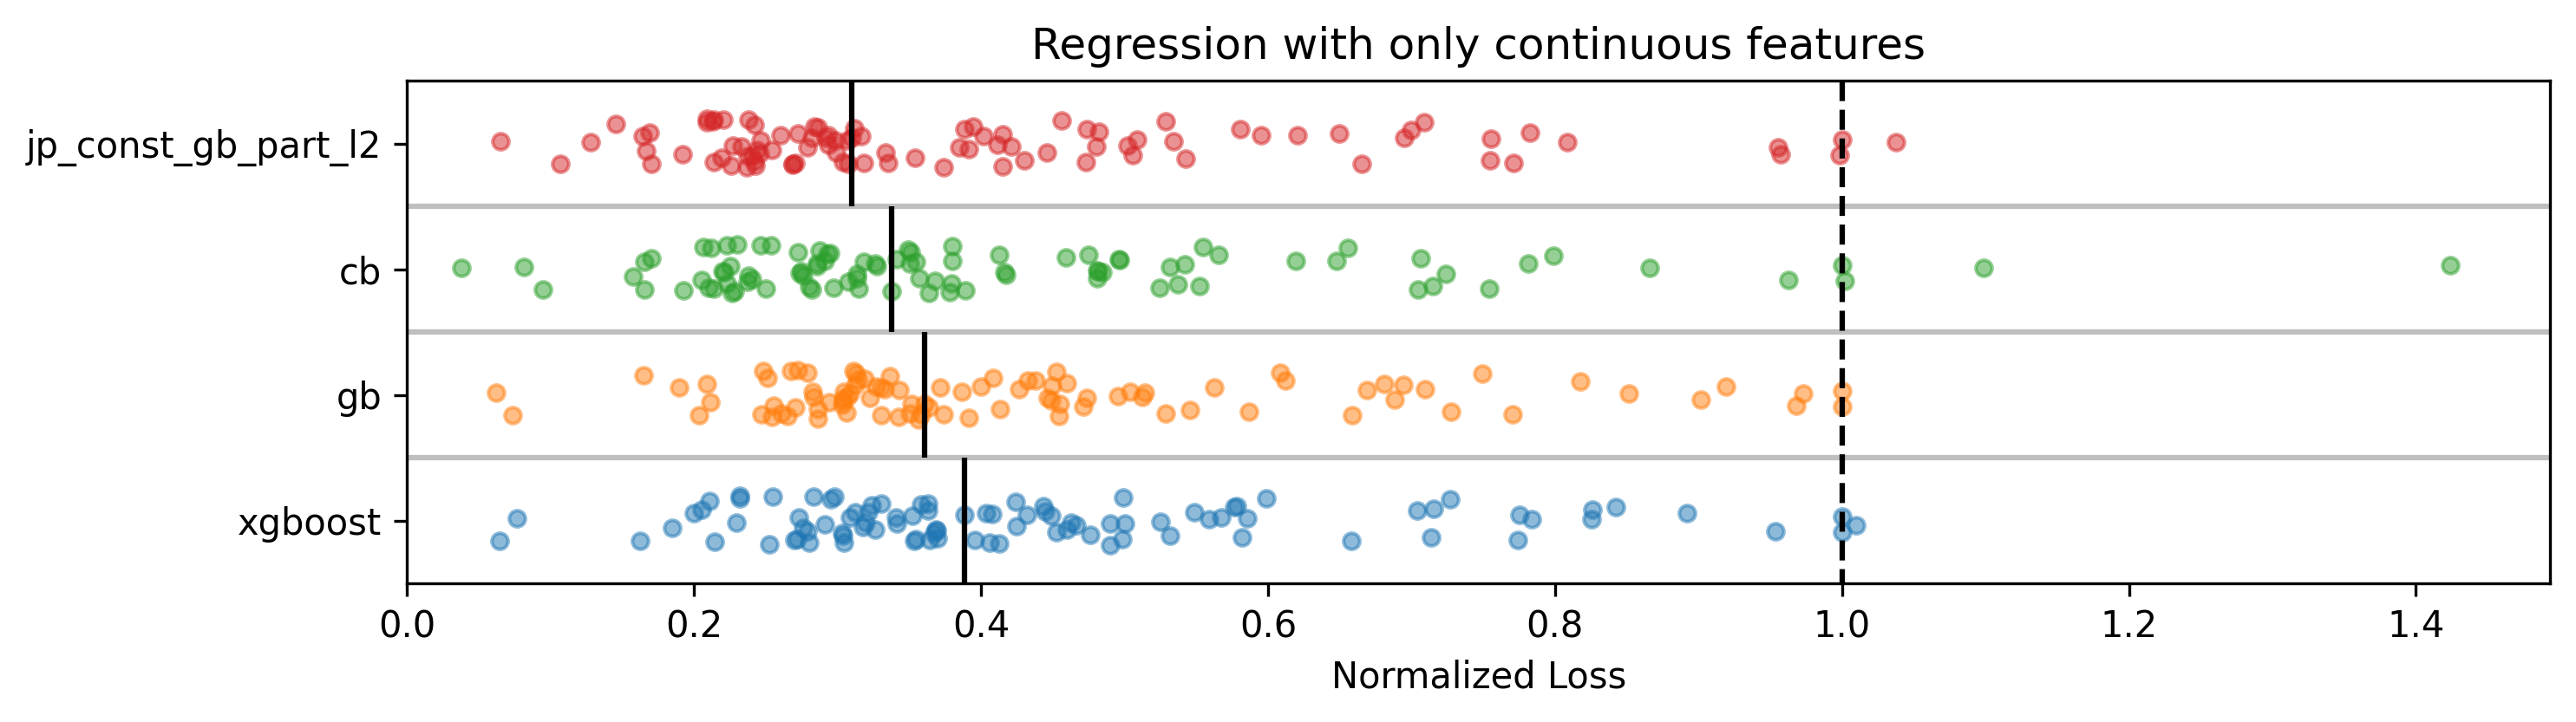

There ar 95 datasets


In [89]:
p_matrix = np.ones((2, 1))
n_datasets = np.zeros((2, 1))

for only_class, only_cont in product([True, False], [True]):
    pred_type = "class" if only_class else "regr"

    print(f"Only class: {only_class}, Only cont: {only_cont}")

    if pred_type not in reg_res:
        continue

    ax, means = plot_strip(
        reg_res[pred_type],
        scatter_kwargs={"alpha": 0.5, "s": 20},
        only_classification=only_class,
        # only_continuous=only_cont,
        plot_kwargs={"dpi": 300},
    )

    title = "Classification" if only_class else "Regression"
    title += (
        " with only continuous features" if only_cont else " with categorical features"
    )

    ax.set_title(title)

    # plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

    plt.show()
    # print(pred_type)
    # print(reg_res[pred_type]["jp_const_gb_part"])

    print(f"There ar {len(reg_res[pred_type]['jp_const_gb_part_l2'])} datasets")

    tmp = compare_methods(
        reg_res[pred_type]["jp_const_gb_part_l2"],
        reg_res[pred_type]["gb"],
        only_class,
    )

    idx = int(only_class)

    p_matrix[idx] = tmp

    for v in reg_res[pred_type]["jp_const_gb_part_l2"].values():
        n_datasets[idx] += v["contains_categorical"] != only_cont

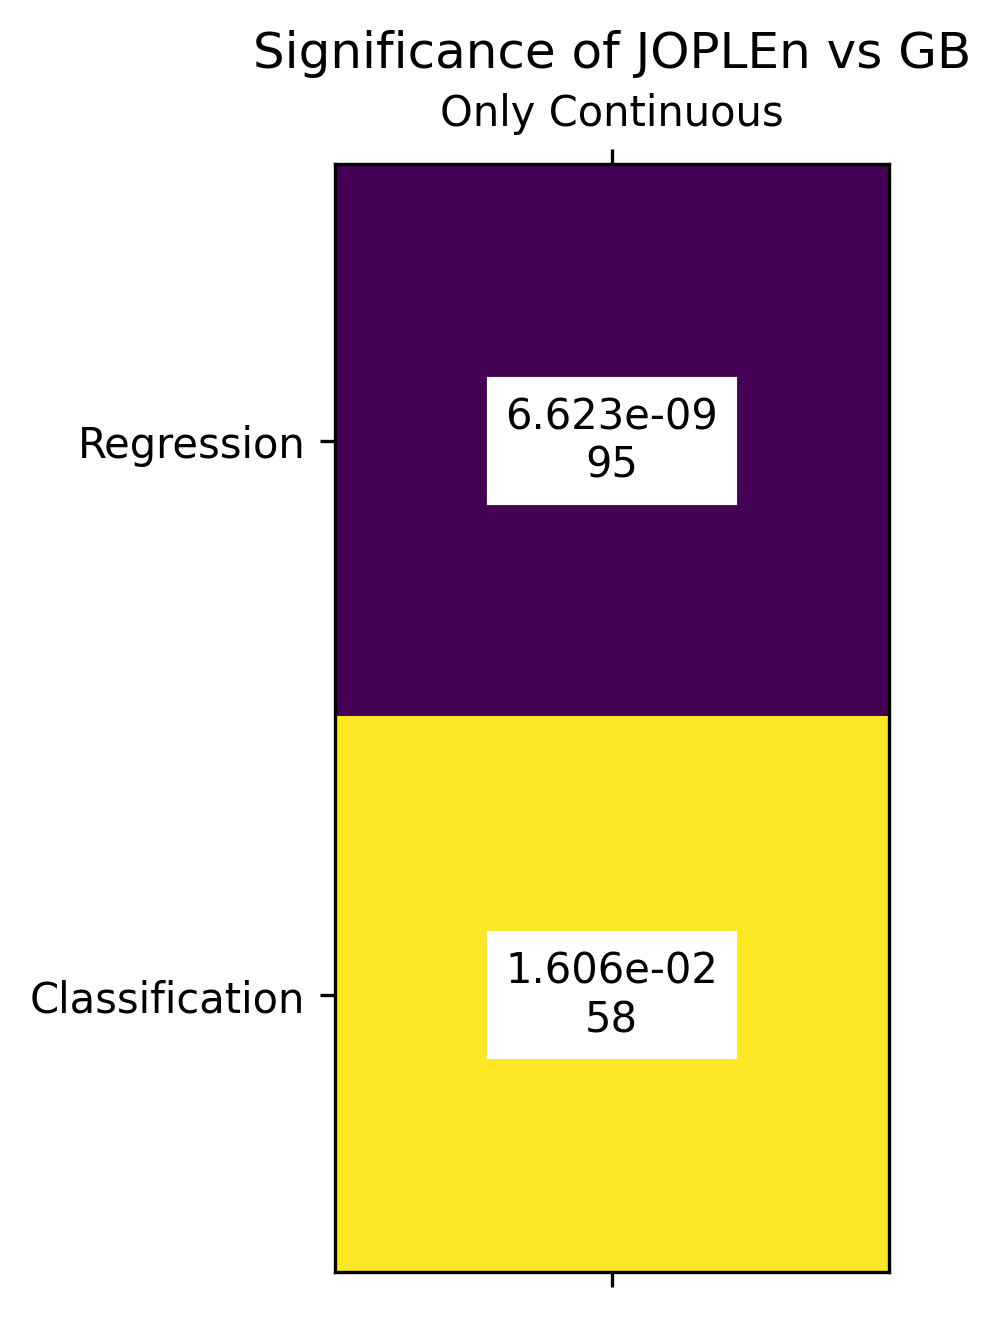

In [90]:
def plot_significance(p_matrix, n_datasets, title):
    fig, ax = plt.subplots(dpi=300)
    cax = ax.matshow(p_matrix, cmap="viridis")

    for (i, j), val in np.ndenumerate(p_matrix):
        ax.text(
            j,
            i,
            f"{val:.3e}\n{int(n_datasets[i,j])}",
            ha="center",
            va="center",
            color="black",
            backgroundcolor="white",
        )

    plt.xticks([0], ["Only Continuous"])
    plt.yticks([0, 1], ["Regression", "Classification"])
    plt.title(title)


plot_significance(p_matrix, n_datasets, title="Significance of JOPLEn vs GB")

In [93]:
print("Comparison between GB and XGBoost")
print(compare_methods(reg_res["class"]["gb"], reg_res["class"]["xgboost"], True))
print(compare_methods(reg_res["regr"]["gb"], reg_res["regr"]["xgboost"], False))

Comparison between GB and XGBoost
0.7125987477490952
0.027725888095527444


In [96]:
print("Comparison between JOPLEn and CatBoost")
print(
    compare_methods(
        reg_res["regr"]["jp_const_gb_part_l2"], reg_res["regr"]["cb"], False
    )
)

Comparison between JOPLEn and CatBoost
0.2676682255754361


In [92]:
np.random.seed(0)

n_replicates = 100

mean_pmatrix = np.zeros((2, 2))

for i in range(n_replicates):
    p_matrix = np.empty((2, 2))
    n_datasets = np.empty((2, 2))
    for only_class, only_cont in product([True, False], [True, False]):
        pred_type = "class" if only_class else "regr"

        first_k_keys = [
            k
            for k, v in reg_res[pred_type]["jp_const_gb_part"].items()
            if v["contains_categorical"] != only_cont
        ]

        first_k_keys = np.random.choice(first_k_keys, 11, replace=True)

        tmp = compare_methods(
            {
                k: v
                for k, v in reg_res[pred_type]["jp_const_gb_part"].items()
                if k in first_k_keys
            },
            {k: v for k, v in reg_res[pred_type]["gb"].items() if k in first_k_keys},
            only_class,
            only_cont,
        )

        idx = (int(only_class), int(only_cont))

        p_matrix[idx] = tmp

        for v in reg_res[pred_type]["jp_const_gb_part"].values():
            n_datasets[idx] += v["contains_categorical"] != only_cont

    mean_pmatrix += p_matrix

mean_pmatrix /= n_replicates

# If we use a small number of datasets for continuous regression, it's still
# significant on average
plot_significance(
    mean_pmatrix,
    np.ones((2, 2)) * 11,
    "Average p-value over 100 replicates",
)

KeyError: 'jp_const_gb_part'

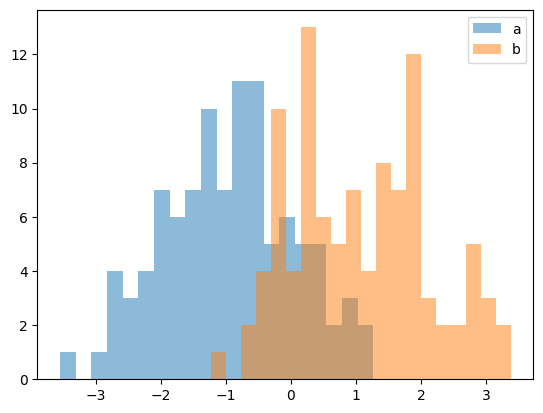

WilcoxonResult(statistic=97.0, pvalue=3.4640105986274376e-17)


In [ ]:
np.random.seed(0)

n_samples = 100

a = np.random.normal(0, 1, n_samples) - 1
b = np.random.normal(0, 1, n_samples) + 1

plt.hist(a, bins=20, alpha=0.5, label="a")
plt.hist(b, bins=20, alpha=0.5, label="b")

plt.legend()

plt.show()

# so the p-value gives the probability that a is greater than b
print(wilcoxon(a, b, alternative="less"))

##### Figure 2: Feature selection

In [ ]:
# load data

st_sel_res = defaultdict(lambda: defaultdict(list))

for method_dir in STFS_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                metadata = defaultdict(list)
                for file in dataset_dir.iterdir():
                    if file.suffix == ".yaml":
                        with open(file, "r") as f:
                            file_content = yaml.safe_load(f)

                        density = file_content["model"]["results"]["density"]
                        metadata["density"].append(density)

                        test_err = file_content["model"]["score"]["norm_error"]["test"]
                        metadata["error"].append(test_err)

                st_sel_res[method_dir.name][dataset_dir.name] = dict(metadata)

for k, v in st_sel_res.items():
    st_sel_res[k] = dict(v)

st_sel_res = dict(st_sel_res)

In [ ]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]

KeyError: 'jp_linear_mu'

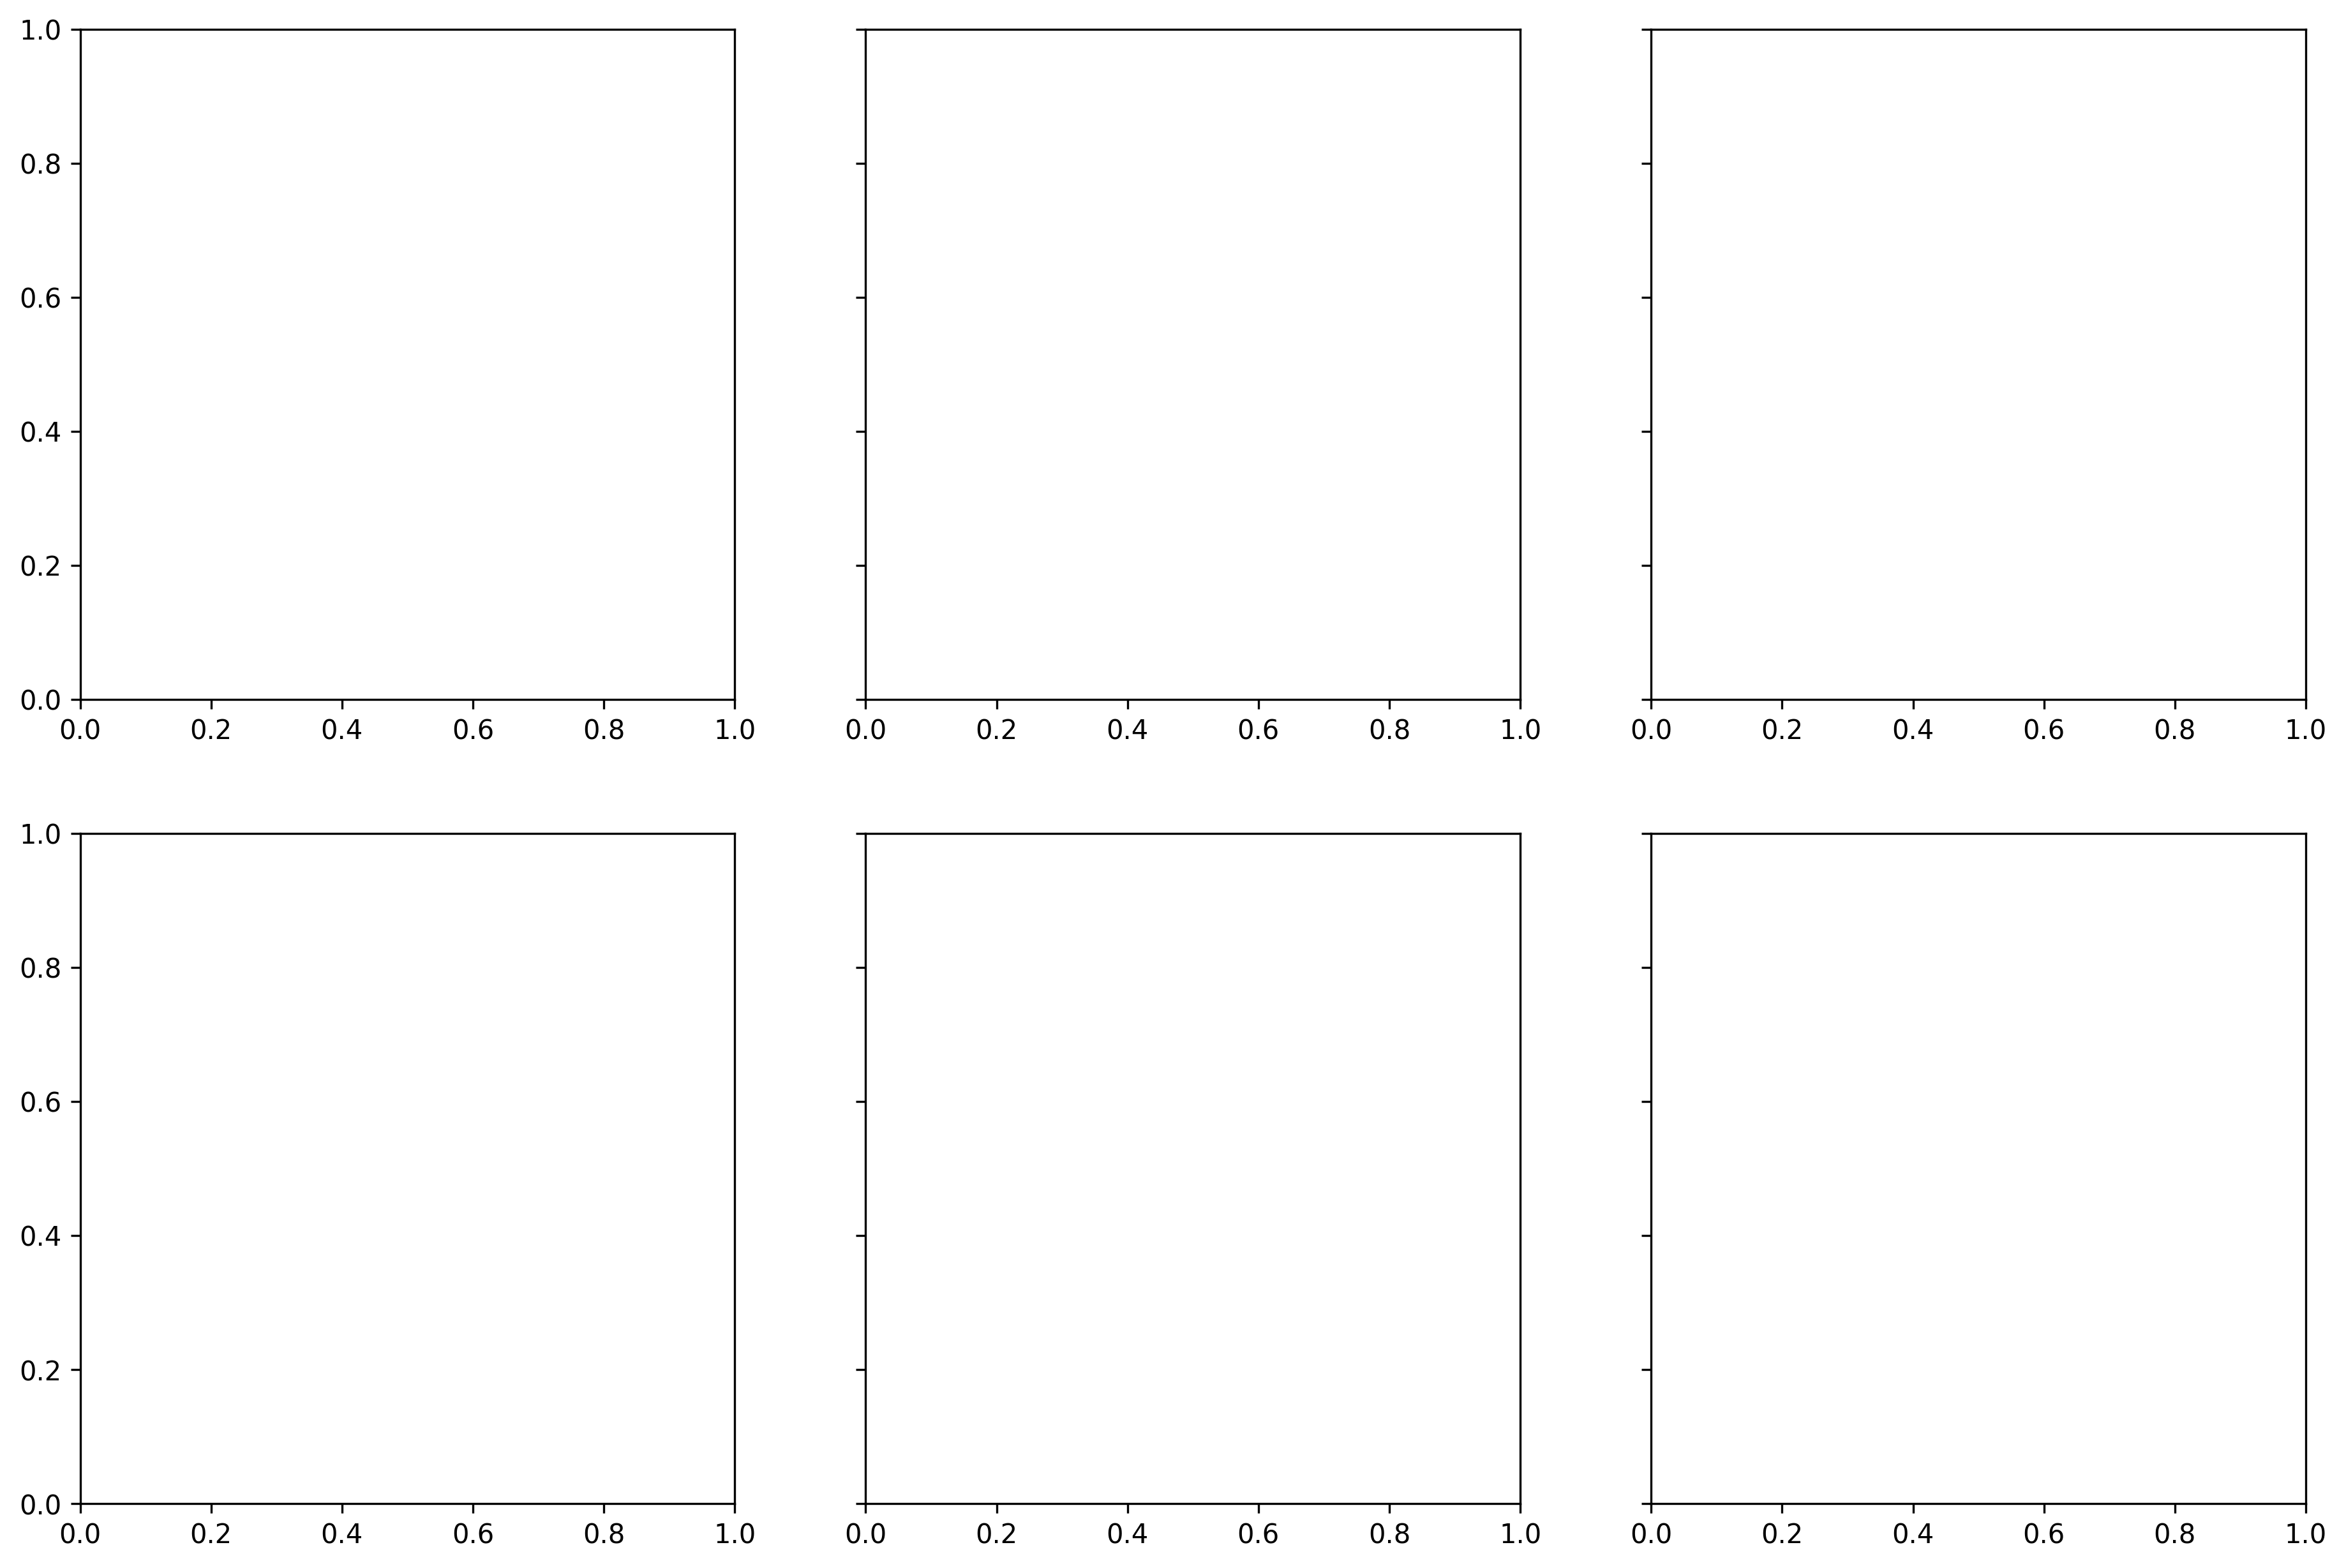

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Generate colormaps
green_colormap = ListedColormap(
    cm.Blues(np.linspace(0.25, 1.0, 4))
)  # 4 shades of green
red_colormap = ListedColormap(cm.Greens(np.linspace(0.5, 0.75, 2)))  # 2 shades of red
blue_colormap = ListedColormap(cm.Reds(np.linspace(0.5, 0.75, 2)))  # 2 shades of blue

LST_DATASETS = [
    "boston",
    "diabetes",
    "riboflavin",
    "pac_dimerization",
    "crime",
    "virus",
]

LST_METHODS = [
    "jp_linear_mu",
    "jp_linear_gb_part",
    "jp_linear_rf_part",
    "jp_linear_linforest_part",
    "lasso",
    "hsic",
    "gb",
    "rf",
    # "nn",
]

solid = LST_METHODS[:4]

colors = [
    *green_colormap.colors,
    *red_colormap.colors,
    *blue_colormap.colors,
]

markers = [
    *(["o"] * 4),
    *(["^"] * 2),
    *(["s"] * 2),
]

renamer = {
    "lasso": "Lasso",
    "gb": "Gradient Boosting (GB)",
    "rf": "Random Forest (RF)",
    "hsic": "HSIC",
    "jp_linear_mu": "JOPLEn (Voronoi)",
    "jp_linear_gb_part": "JOPLEn (GB)",
    "jp_linear_rf_part": "JOPLEn (RF)",
    "jp_linear_linforest_part": "JOPLEn (LF)",
    "nn": "Deep Feature Selection",
    "boston": "Boston Housing",
    "pac_dimerization": "PAC Dimerization",
}


n_ds = len(LST_DATASETS)

fig, axs = plt.subplots(2, n_ds // 2, figsize=(5 * n_ds // 2, 10), sharey=True, dpi=300)

zorder = 10

for ax, ds in zip(axs.ravel(), LST_DATASETS):
    for i, (k, c, m) in enumerate(zip(LST_METHODS, colors, markers)):
        if ds not in st_sel_res[k]:
            continue

        model_score = np.array(st_sel_res[k][ds]["error"])
        model_density = np.array(st_sel_res[k][ds]["density"])

        pareto_density, pareto_score = pareto_front(model_score, model_density)
        ax.plot(
            pareto_density,
            pareto_score,
            label=renamer[k],
            marker=m,
            linestyle="-" if k in solid else ":",
            color=c,
            markersize=5,
            zorder=zorder - i,
        )

    ax.set_title(renamer.get(ds, ds.title()))

axs[0, 0].legend()

for ax in axs.T:
    ax[1].set_xlabel("Density")

for ax in axs:
    ax[0].set_ylabel("Test Error")

plt.savefig("plots/fig2.pdf")
plt.show()

##### Singletask sparsity pattern

In [ ]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(weights, transpose=False, figsize=(5, 5)):
    n_feats, n_cells = weights.shape
    weights = weights

    weights = scale_matrix(weights, weights.min(), weights.max())

    fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True, sharex=True, dpi=300)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    if not transpose:
        ax.matshow(weights, **params)
        ax.set_xlabel("Partitions and cells")
        ax.set_ylabel("Features")
    else:
        ax.matshow(weights.T, **params)
        ax.set_xlabel("Features")
        ax.set_ylabel("Partitions and cells")

    plt.tight_layout()
    return fig, ax

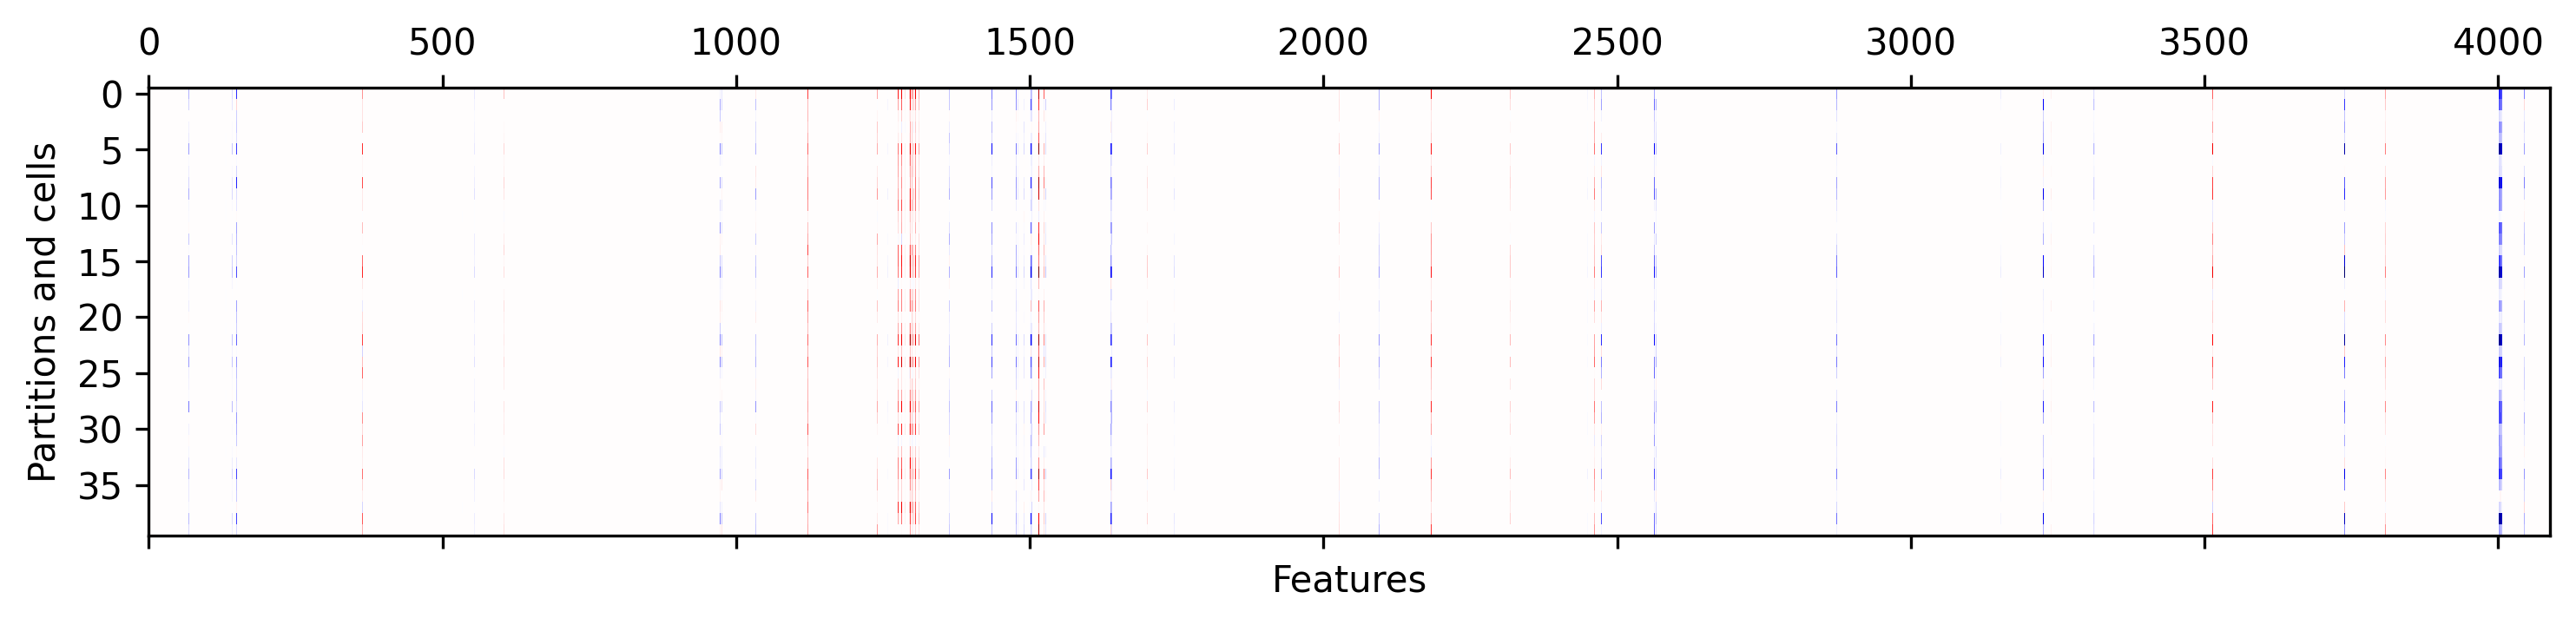

In [ ]:
misc_data_path = Path() / "misc_data"

riboflavin_weights = np.loadtxt(
    misc_data_path / "riboflavin_weights.csv",
    delimiter=",",
)

_, ax = plot_joplen_weights(riboflavin_weights, True, (10, 2.5))

plt.savefig("plots/fig3.pdf", bbox_inches="tight")
plt.show()

##### Multitask sparsity pattern

In [ ]:
def plot_joplen_weights(core_weights, task_weights, axs=None):
    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    # axs[0].set_title("Common weights")
    axs[1].matshow(task_weights, **params)
    # axs[1].set_title("Task-specific weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_ylabel("Features")

    axs[1].set_xlabel("Tasks, partitions, and cells")

    plt.tight_layout()

    return ax

In [ ]:
import pandas as pd

OUT_PATH = Path() / "experiments" / "manual" / "multitask"


# load data
def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

In [ ]:
res = load_results("sarcos")
(
    sarcos_jp_res,
    sarcos_dl_res,
    sarcos_dummy_results,
    sarcos_linear_results,
    sarcos_gb_results,
    sarcos_jp_core,
    sarcos_jp_task,
    sarcos_dl_core,
    sarcos_dl_task,
) = res

res = load_results("parkinsons")
(
    park_jp_res,
    park_dl_res,
    park_dummy_results,
    park_linear_results,
    park_gb_results,
    park_jp_core,
    park_jp_task,
    park_dl_core,
    park_dl_task,
) = res

res = load_results("nanoparticle")
(
    nano_jp_res,
    nano_dl_res,
    nano_dummy_results,
    nano_linear_results,
    nano_gb_results,
    nano_jp_core,
    nano_jp_task,
    nano_dl_core,
    nano_dl_task,
) = res

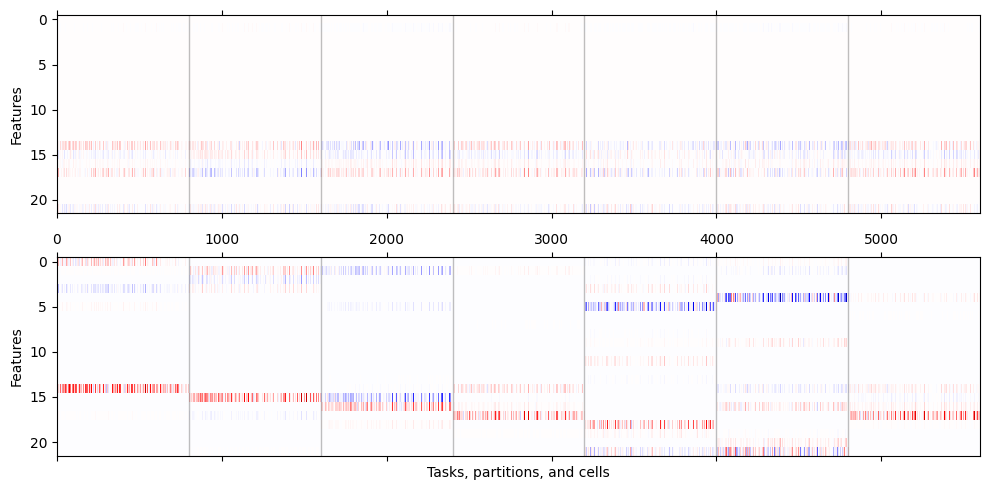

In [ ]:
ax = plot_joplen_weights(sarcos_jp_core, sarcos_jp_task)

plt.savefig("plots/fig4.pdf", bbox_inches="tight")

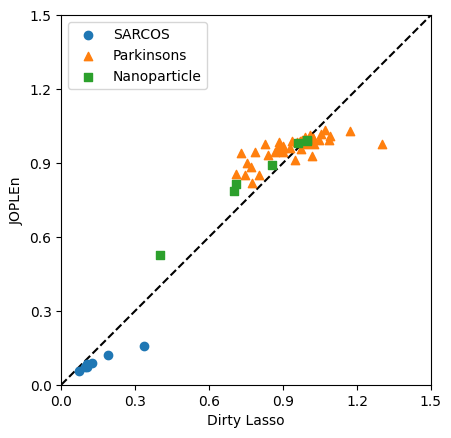

In [ ]:
plt.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

plt.scatter(
    park_dl_res["test"] / park_dummy_results["test"],
    park_jp_res["test"] / park_dummy_results["test"],
    label="Parkinsons",
    marker="^",
    zorder=10,
)

plt.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Nanoparticle",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

plt.plot(x, x, color="k", linestyle="--", zorder=0)

plt.xticks(x)
plt.yticks(x)

plt.xlabel("Dirty Lasso")
plt.ylabel("JOPLEn")
plt.legend()
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.gca().set_aspect("equal")

plt.show()

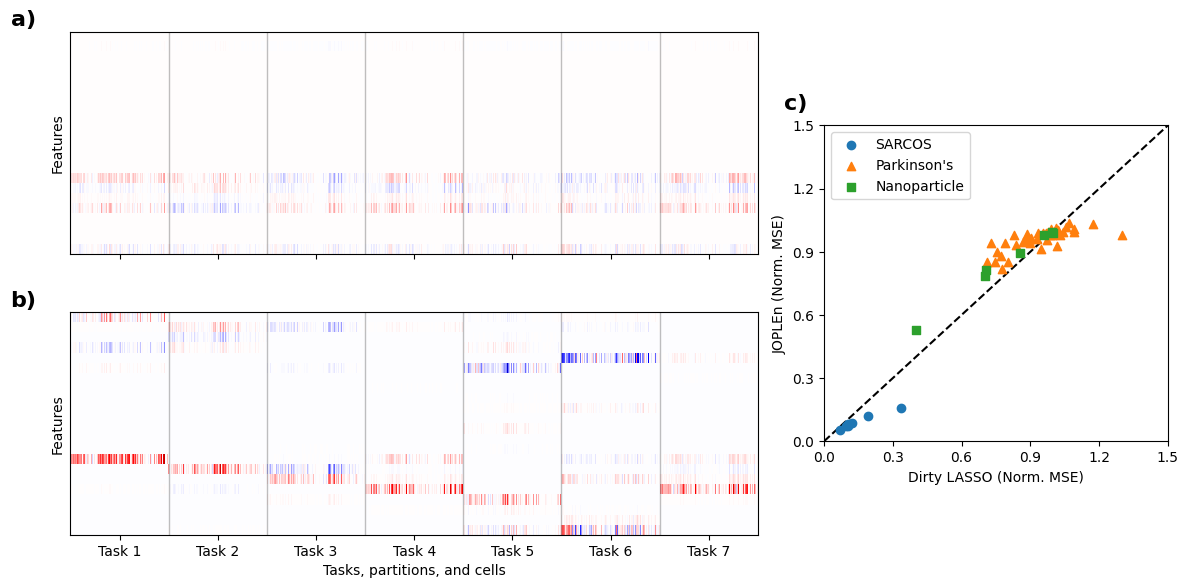

In [ ]:
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(12, 6))  # Adjust the overall size of the figure

# Define the GridSpec layout
# The right plot will only take up 75% of the vertical space and be center aligned
gs = GridSpec(6, 2, width_ratios=[2, 1])

# Create three subplots
ax1 = fig.add_subplot(gs[0:3, 0])  # Top left (occupying the first half vertically)
ax2 = fig.add_subplot(
    gs[3:6, 0], sharex=ax1, sharey=ax1
)  # Bottom left (occupying the second half vertically)
ax3 = fig.add_subplot(
    gs[1:5, 1]
)  # Right (center aligned and taking up 75% of vertical space)

# plot sparsity
plot_joplen_weights(sarcos_jp_core, sarcos_jp_task, axs=[ax1, ax2])

# plot performance
ax3.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

ax3.scatter(
    park_dl_res["test"] / park_dummy_results["test"],
    park_jp_res["test"] / park_dummy_results["test"],
    label="Parkinson's",
    marker="^",
    zorder=10,
)

ax3.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Nanoparticle",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

ax3.plot(x, x, color="k", linestyle="--", zorder=0)

ax3.set_xticks(x)
ax3.set_yticks(x)

ax3.set_xlabel("Dirty LASSO (Norm. MSE)")
ax3.set_ylabel("JOPLEn (Norm. MSE)")
ax3.legend()
ax3.set_xlim(0, 1.5)
ax3.set_ylim(0, 1.5)

for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 7) * 800 + 400)
    ax.tick_params(labelleft=False, left=False)

ax1.set_xticklabels([f"Task {i}" for i in range(1, 8)])

ax1.tick_params(top=False, labeltop=False, bottom=True, labelbottom=False)
ax2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

text_params = {
    "fontsize": 16,
    "fontweight": "bold",
    "va": "top",
    "ha": "right",
}

# Add number to each subplot
ax1.text(-0.05, 1.1, "a)", transform=ax1.transAxes, **text_params)
ax2.text(-0.05, 1.1, "b)", transform=ax2.transAxes, **text_params)
ax3.text(-0.05, 1.1, "c)", transform=ax3.transAxes, **text_params)

# Show the plot layout
plt.tight_layout()
plt.savefig("plots/fig4.pdf", bbox_inches="tight")
plt.show()

NameError: name 'NAMES' is not defined

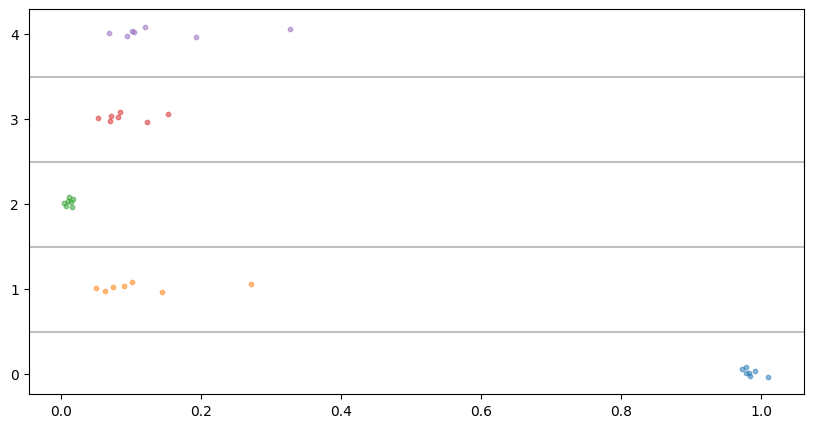

In [ ]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 0.5, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.xlim(0, 5)

plt.show()